In [ ]:
import pandas as pd
import pymongo
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
flight_df = pd.read_csv('Flights_Delay.csv')

In [ ]:
mean_num = flight_df['ARRIVAL_DELAY'].mean()
flight_df['ARRIVAL_DELAY'] = flight_df['ARRIVAL_DELAY'].fillna(mean_num)

In [ ]:
mean_num = flight_df['DEPARTURE_DELAY'].mean()
flight_df['DEPARTURE_DELAY'] = flight_df['DEPARTURE_DELAY'].fillna(mean_num)

In [ ]:
mean_num = flight_df['AIR_TIME'].mean()
flight_df['AIR_TIME'] = flight_df['AIR_TIME'].fillna(mean_num)

In [ ]:
flight_df['DEPARTURE_TIME'] = flight_df['DEPARTURE_TIME'].fillna(0)
flight_df['ARRIVAL_TIME'] = flight_df['ARRIVAL_TIME'].fillna(0)
flight_df['ARRIVAL_TIME']

In [ ]:
flight_df['DEPARTURE_TIME'] = flight_df['DEPARTURE_TIME'].astype('int')
flight_df['DEPARTURE_TIME'] = flight_df['DEPARTURE_TIME'].apply(lambda x : x //100 )

In [ ]:
flight_df['ARRIVAL_TIME'] = flight_df['ARRIVAL_TIME'].astype('int')
flight_df['ARRIVAL_TIME'] = flight_df['ARRIVAL_TIME'].apply(lambda x : x //100 )

In [ ]:
flight_df['ARRIVAL_TIME'].value_counts()

### 1. Create collections “flights” inside database “airline_delayDB”
### 2. How would you insert this entire dataset into a MongoDB collection named flights? Describe the structure of each document.


In [ ]:

client = pymongo.MongoClient('localhost:27017')
db = client['flight_db']

flight_docs = flight_df.to_dict('records')

collection_name = 'flight'

if collection_name in db.list_collection_names():
    db[collection_name].drop()

flights = db[collection_name]

if flight_docs:
    flights.insert_many(flight_docs)


### 3. Write a MongoDB command to insert a single flight record from the dataset.


In [ ]:

flights.insert_one({
    "ID": 56000,
    "YEAR": 2015,
    "MONTH": 3,
    "DAY": 4,
    "DAY_OF_WEEK": 3,
    "AIRLINE": "EV",
    "FLIGHT_NUMBER": 5170,
    "TAIL_NUMBER": "N842AS",
    "ORIGIN_AIRPORT": "CVG",
    "DESTINATION_AIRPORT": "XNA",
    "SCHEDULED_DEPARTURE": 935,
    "DEPARTURE_TIME": 954,
    "DEPARTURE_DELAY": 19,
    "TAXI_OUT": 16,
    "WHEELS_OFF": 1010,
    "SCHEDULED_TIME": 115,
    "ELAPSED_TIME": 129,
    "AIR_TIME": 108,
    "DISTANCE": 562,
    "WHEELS_ON": 1058,
    "TAXI_IN": 5,
    "SCHEDULED_ARRIVAL": 1030,
    "ARRIVAL_TIME": 1103,
    "ARRIVAL_DELAY": 33,
    "DIVERTED": 0,
    "CANCELLED": 0,
    "CANCELLATION_REASON": "",
    "AIR_SYSTEM_DELAY": 14,
    "SECURITY_DELAY": 0,
    "AIRLINE_DELAY": 19,
    "LATE_AIRCRAFT_DELAY": 0,
    "WEATHER_DELAY": 0
})

### 4. Write a MongoDB query to find all flights that were delayed by more than 60 minutes.


In [ ]:
delayed_flights = flights.find({'$or': [{'ARRIVAL_DELAY': {'$gt' : 60}},{'DEPARTURE_DELAY' : {'$gt' : 60}}]},{'_id':0})
for flight in delayed_flights:
    print(flight)

#### 5. How would you query all flights that were cancelled (CANCELLED flag set to 1) and return only the AIRLINE, ORIGIN_AIRPORT, and CANCELLATION_REASON fields?

In [ ]:

cancelled_flights = flights.find({'CANCELLED': 1},
                                 {'_id':0,'AIRLINE':1,'ORIGIN_AIRPORT':1,'CANCELLATION_REASON':1}
                                 )
for flight in cancelled_flights:
    print(flight)

#### 6. Using MongoDB’s aggregation framework, how would you calculate the average arrival delay (ARRIVAL_DELAY) for each airline? [Create a suitable plot using matplotlib/seaborn]

C:\Users\Administrator\AppData\Local\Temp\ipykernel_8324\3510125664.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=delay_df, x='_id', y='avgDelay', palette='viridis')


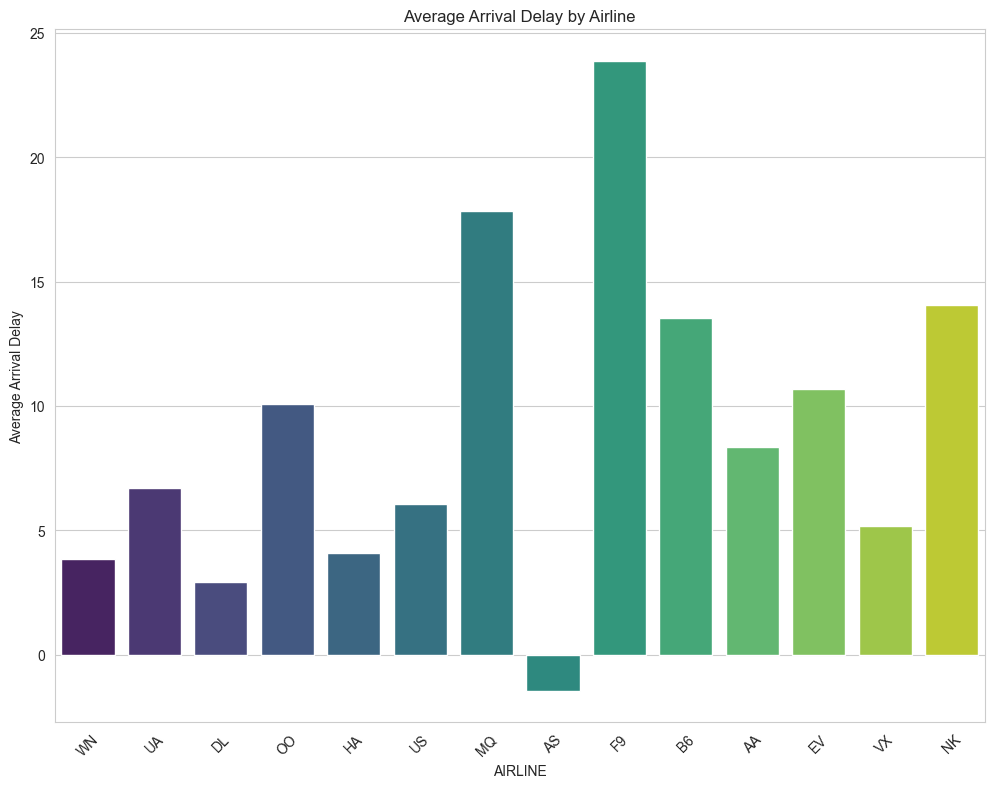

In [34]:
# 6. Using MongoDB’s aggregation framework, how would you calculate the average arrival delay (ARRIVAL_DELAY) 
# for each airline? [Create a suitable plot using matplotlib/seaborn]
avg_flight_delays = flights.aggregate([
    {'$group': {'_id':'$AIRLINE', 'avgDelay': {'$avg':'$ARRIVAL_DELAY'}}},
    {'$project': {'AIRLINE':1,'avgDelay' :{'$round': ['$avgDelay',2]}}}
])

delay_df = pd.DataFrame(list(avg_flight_delays))

plt.figure(figsize=(12, 9))
sns.set_style('whitegrid')
sns.barplot(data=delay_df, x='_id', y='avgDelay', palette='viridis')
plt.xlabel('AIRLINE')
plt.ylabel('Average Arrival Delay')
plt.title('Average Arrival Delay by Airline')
plt.xticks(rotation=45)
plt.show()

#### 7. Days of months with respect to average of arrival delays. [Create a suitable plot using matplotlib/seaborn]


C:\Users\Administrator\AppData\Local\Temp\ipykernel_8324\373651203.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=day_df, x='DAY', y='avgDelay', palette='viridis')


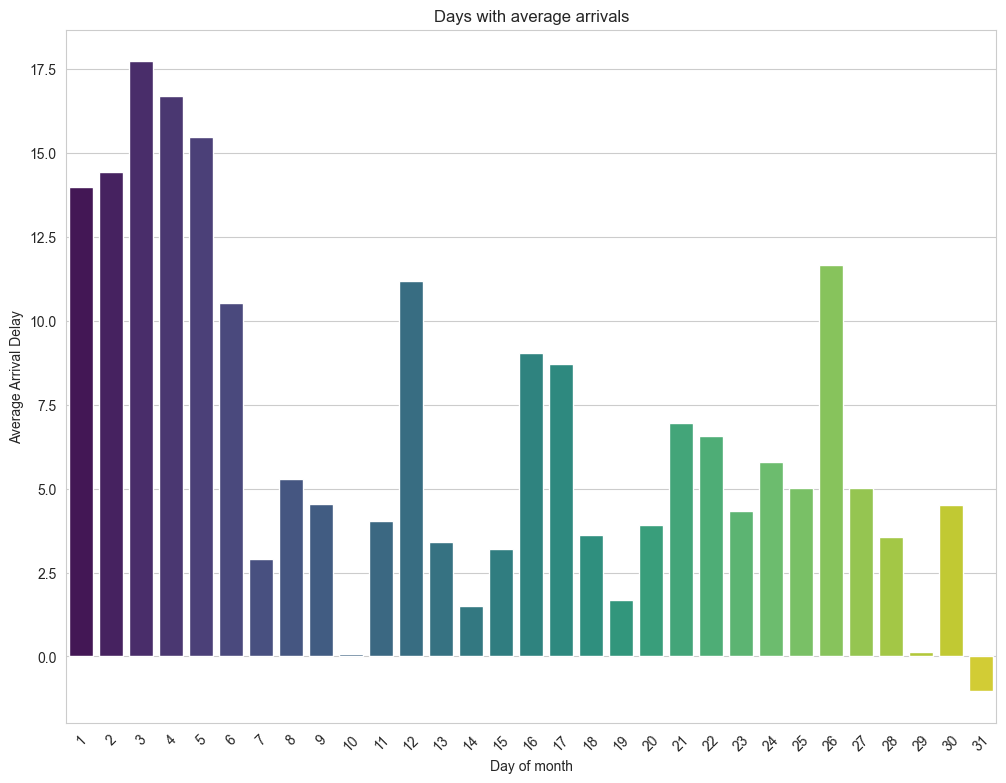

In [35]:
day_delays = flights.aggregate([
    {'$group': {'_id':'$DAY', 'avgDelay': {'$avg':'$ARRIVAL_DELAY'}}},
    {'$project': {'_id' :0,'DAY':'$_id','avgDelay' :{'$round': ['$avgDelay',2]}}},
    {'$sort':{'_id':1}}
])

day_df = pd.DataFrame(list(day_delays))

plt.figure(figsize=(12, 9))
sns.set_style('whitegrid')
sns.barplot(data=day_df, x='DAY', y='avgDelay', palette='viridis')
plt.xlabel('Day of month')
plt.ylabel('Average Arrival Delay')
plt.title('Days with average arrivals')
plt.xticks(rotation=45)
plt.show()

#### 8. Write a MongoDB aggregation pipeline to find the top 10 airports with the highest average total delay (DEPARTURE_DELAY + ARRIVAL_DELAY)

In [ ]:
day_delays = flights.aggregate([
    {'$group': {'_id':'$AIRLINE', 'avgDelay': {'$avg':{'$add' :['$DEPARTURE_DELAY','$ARRIVAL_DELAY'] }}}},
    {'$project': {'_id' : 0,'AIRLINE':'$_id','avgDelay' :{'$round': ['$avgDelay',2]}}},
    {'$sort':{'avgDelay':-1}},
    {'$limit':10}
])

for i in day_delays:
    print(i)

#### 9. Explain how you would create an index on the ORIGIN_AIRPORT and DESTINATION_AIRPORT fields to optimize queries filtering by these fields.


In [ ]:
flights.create_index(['ORIGIN_AIRPORT','DESTINATION_AIRPORT'])

for i in flights.find({},{'_id':0,'ORIGIN_AIRPORT':1,'DESTINATION_AIRPORT':1}):
    print(i)


#### 10. Arrange weekdays with respect to the average arrival delays caused. [Create a suitable plot using matplotlib/seaborn]

In [ ]:
week_delays = flights.aggregate([
    {'$group': {'_id':'$DAY_OF_WEEK', 'avgDelay': {'$avg':'$ARRIVAL_DELAY'}}},
    {'$project': {'_id':0 ,'DAY_OF_WEEK':'$_id','avgDelay' :{'$round': ['$avgDelay',2]}}},
    {'$sort':{'_id':1}}
])

week_df = pd.DataFrame(list(week_delays))
week_df['_id'] = week_df['DAY_OF_WEEK'].apply(lambda x:'MONDAY' if x == 1 
                                         else 'TUESDAY' if x == 2 
                                         else 'WEDNESDAY' if x == 3 
                                         else 'THURSDAY' if x==4 
                                         else 'FRIDAY' if x==5 
                                         else 'SATURDY' if x==6 
                                         else 'SUNDAY')
plt.figure(figsize=(11, 6))
sns.set_style('whitegrid')
sns.barplot(data=week_df, x='_id', y='avgDelay', palette='viridis')
plt.xlabel('Day of week')
plt.ylabel('Average Arrival Delay')
plt.title('Week Days with average arrival delays')
plt.xticks(rotation=45)
plt.show()

#### 11. Arrange Days of month as per cancellations done in descending order. [Create a suitable plot using matplotlib/seaborn]


In [ ]:
cancellation_days = flights.aggregate([
    {'$match': {'CANCELLED' : 1}},
    {'$group': {'_id': '$DAY', 'cancellations': {'$sum': '$CANCELLED'}}},
    {'$project': {'_id': 0, 'DAY': '$_id', 'cancellations': 1}},
    {'$sort': {'cancellations': -1}}
])

cancellation_df = pd.DataFrame(cancellation_days)

plt.figure(figsize=(12, 8))
sns.set_style('darkgrid')
sns.barplot(data=cancellation_df, x='DAY', y='cancellations', palette='viridis')
plt.xlabel('Day of the Month')
plt.ylabel('Total Cancellations')
plt.title('Cancellation Count per Day of the Month')
plt.xticks(rotation=45)
plt.show()


#### 12. Find the busiest airports with respect to day of week. Represent it by using suitable plot.


In [37]:
busiest_airports = flights.aggregate([
    {'$group': {'_id': {'AIRPORT': '$ORIGIN_AIRPORT', 'DAY_OF_WEEK': '$DAY_OF_WEEK'},'count': {'$sum': 1}}},
    {'$project': {'_id': 0,'AIRPORT': '$_id.AIRPORT','DAY_OF_WEEK': '$_id.DAY_OF_WEEK','count': 1}},
    {'$sort': {'DAY_OF_WEEK': 1,'count': -1}},
    {'$group': {'_id': '$DAY_OF_WEEK','busiest_airport': {'$first': '$AIRPORT'},'count': {'$first': '$count'}}},
    {'$project': {'_id': 0,'DAY_OF_WEEK': '$_id','busiest_airport': 1,'count': 1}}
])

for i in busiest_airports:
    print(i)

# buzy_airport_df = pd.DataFrame(busy_airport)

# plt.figure(figsize=(12, 8))
# sns.barplot(data=buzy_airport_df, x='DAY_OF_WEEK', y='COUNT', hue='AIRPORT', palette='viridis')
# plt.title('Busiest Airports with respect to day of week')
# plt.xlabel('Day of the Week')
# plt.ylabel('People count')
# plt.legend(title='Airport')
# plt.show()

{'busiest_airport': 'ATL', 'count': 475, 'DAY_OF_WEEK': 2}
{'busiest_airport': 'ATL', 'count': 574, 'DAY_OF_WEEK': 5}
{'busiest_airport': 'ATL', 'count': 555, 'DAY_OF_WEEK': 1}
{'busiest_airport': 'ATL', 'count': 413, 'DAY_OF_WEEK': 6}
{'busiest_airport': 'ATL', 'count': 499, 'DAY_OF_WEEK': 7}
{'busiest_airport': 'ATL', 'count': 505, 'DAY_OF_WEEK': 3}
{'busiest_airport': 'ATL', 'count': 556, 'DAY_OF_WEEK': 4}


#### 13. Find top 10 Airlines of US. Represent it by using suitable plot.


In [ ]:
top_airlines = flights.aggregate([
    {'$match':{'AIRLINE':'US'}},
    {'$group':{'_id':'$FLIGHT_NUMBER','count':{'$sum' : 1}}},
    {'$project':{'_id':0,'FLIGHT_NUMBER':'$_id','count':1}},
    {'$sort':{'count':-1}},
    {'$limit':10}
])
top_airlines_df = pd.DataFrame(top_airlines)

plt.figure(figsize=(12, 8))
sns.set_style('darkgrid')
sns.barplot(x=top_airlines_df['FLIGHT_NUMBER'], y=top_airlines_df['count'], palette='viridis')
plt.xlabel('Flight number')
plt.ylabel('Count of flights')
plt.title('Top 10 flights in US')
plt.xticks(rotation=45)
plt.show()


#### 14. Finding airlines that make the maximum, minimum number of cancellations.


In [ ]:
# max_cancel = flights.aggregate([
#     { '$match': { 'CANCELLED': 1 } },
#     { '$group': {
#         '_id': "$AIRLINE",
#         'cancellations': { '$sum': 1 }
#     }},
#     {'$sort':{'cancellations':-1}},
#     {'$limit':1},
#     { '$project': {
#         '_id': 0,
#         'AIRLINE': "$_id",
#         'cancellations': 1
#     }}
# ])


minmax_cancel = flights.aggregate([
    { '$match': { 'CANCELLED': 1 } },
    { '$group': {
        '_id': "$AIRLINE",
        'cancellations': { '$sum': 1 }
    }},
    { '$facet': { 'max_cancel': [
            {'$sort': {'cancellations': -1}},
            {'$limit': 1},
            { '$project': {
                '_id': 0,
                'AIRLINE': "$_id",
                'cancellations': 1
            }}],
        'min_cancel': [
            {'$sort': {'cancellations': 1}},
            {'$limit': 1},
            { '$project': {
                '_id': 0,
                'AIRLINE': "$_id",
                'cancellations': 1}}]
                }
    }
])

for i in minmax_cancel: 
    print(i)

#### 15. Find and show airlines names in descending that make the most number of diversions made. [Create a suitable plot using matplotlib/seaborn]


In [ ]:
max_diversion = flights.aggregate([
    { '$group': {
        '_id': None,
        'max_diversion': {'$max':'DIVERTED'}
    }},
    { '$lookup': {
        'from': 'flights',
        'pipeline': [
            { '$match': { 'DIVERTED': '$max_diversion' } },
            { '$project': { '_id': 0, 'AIRLINE': 1, 'DIVERTED': 1 } }
        ],
        'as': 'res'
    }},
    {'$unwind': '$res'},
    { '$project': {
        '_id': 0,
        'AIRLINE': "$res.AIRLINE",
        'DIVERTED': "$res.DIVERTED"
    }},
    {'$sort':{'AIRLINE':-1}}
])

for i in max_diversion:
    print(i)

In [ ]:
for i in flights.find_one():
    print(i)

#### 16. Finding days of month that see the most number of diversion and delays.
 

In [ ]:
number_of_diversions = flights.aggregate([
    {'$group': {'_id': '$DAY','total_diversions': { '$sum': '$DIVERTED' },
                'total_delays': { '$sum': { '$add': ['$ARRIVAL_DELAY','$DEPARTURE_DELAY']}}}},
    {'$project': {'_id': 0,'DAY': '$_id','total_diversions': 1,'total_delays': 1}},
    {'$sort': {'total_diversions': -1,'total_delays': -1}}
])

for i in number_of_diversions:
    print(i)


#### 17. Write a MongoDB query to find the flights with the shortest and longest AIR_TIME. Return the flightNumber, airline, and AIR_TIME.

In [ ]:
long_short_flights = flights.aggregate([
    {'$facet':{
        'longest_time': [
            {'$project': {'_id': 0,'FLIGHT_NUMBER': 1,'AIRLINE':1,'AIR_TIME':1}},
            {'$sort': {'AIR_TIME':-1}},
            {'$limit': 1}
        ],
        'shortest_time': [
            {'$project': {'_id': 0,'FLIGHT_NUMBER': 1,'AIRLINE':1,'AIR_TIME':1}},
            {'$sort': {'AIR_TIME':1}},
            {'$limit': 1}
        ],
    }}
])
print(list(long_short_flights))

#### 18. Finding all diverted Route from a source to destination Airport & which route is the most diverted route.


In [ ]:
flight_df['DIVERTED'].value_counts()

In [ ]:
most_diverted = flights.aggregate([
    {'$match' : {'DIVERTED':1}},
    {'$group' : {'_id':{'ORIGIN_AIRPORT':'$ORIGIN_AIRPORT','DESTINATION_AIRPORT':'$DESTINATION_AIRPORT'},'COUNT': {'$sum':1}}},
    {'$project': {'_id':0,'ORIGIN_AIRPORT':'$_id.ORIGIN_AIRPORT','DESTINATION_AIRPORT':'$_id.DESTINATION_AIRPORT','COUNT':1}},
    {'$sort':{'COUNT':-1}},
    {'$limit':1}
])

for i in most_diverted:
    print(i)

#### 19. Write a MongoDB aggregation pipeline to calculate the all aggregated values for departure delay (DEPARTURE_DELAY) and arrival delay (ARRIVAL_DELAY) for each airline, excluding flights that were either cancelled or diverted.

In [ ]:
departure_delay = flights.aggregate([
    {'$match': {'$and': [{'DIVERTED': 0},{'CANCELLED': 0}]}},
    {'$project': {'_id': 0,'DEPARTURE_DELAY': 1,'ARRIVAL_DELAY': 1}}
])

for i in departure_delay:
    print(i)

#### 20. Write a MongoDB query to find all flights that were delayed due to WEATHER_DELAY but were not cancelled or diverted. Include the flightNumber, airline, originAirport, and destinationAirport in the results.

In [ ]:
weather_delay = flights.aggregate([
    {'$match': {'WEATHER_DELAY': {'$gt':0.0},'$and': [{'DIVERTED': 0},{'CANCELLED': 0}]}},
    {'$project': {'_id': 0,'FLIGHT_NUMBER': 1,'AIRLINE': 1,'DESTINATION_AIRPORT':1,'ORIGIN_AIRPORT':1}}
])

for i in weather_delay:
    print(i)

#### 21. Write a MongoDB query to find all flights that were delayed both at departure (DEPARTURE_DELAY) and arrival (ARRIVAL_DELAY). Return the count of such Flights which are delayed.


In [ ]:
both_delay = flights.aggregate([
    {'$match': {'$and': [{'DEPARTURE_DELAY': {'$gt' : 0.0}},{'ARRIVAL_DELAY': {'$gt' : 0.0}}]}},
    {'$group': {'_id':None,'COUNT':{'$sum':1}}},
    {'$project': {'_id': 0,'FLIGHT_NUMBER':1,'COUNT':1}}
])

for i in both_delay:
    print(i)

#### 22. Write a MongoDB query to calculate the frequency of flight takeoffs and landings within defined time intervals (e.g., every hour) throughout the day. Generate a Suitable Plot.

In [ ]:
flight_df['D'].dtype

In [ ]:
flight_freq = flights.aggregate([
    {'$match': {'DEPARTURE_TIME': {'$gt': 0}, 'ARRIVAL_TIME': {'$gt': 0, '$lt':1000}}},
    {'$group': {'_id': {'DEPARTURE_TIME': '$DEPARTURE_TIME', 'ARRIVAL_TIME': '$ARRIVAL_TIME'}, 'COUNT': {'$sum': 1}}},
    {'$project' : {'_id':0,'DEPARTURE_TIME':'$_id.DEPARTURE_TIME','ARRIVAL_TIME':'$_id.ARRIVAL_TIME','COUNT':1}}
])

flight_freq_df = pd.DataFrame(flight_freq)
# sns.scatterplot(flight_freq_df,x='DEPARTURE_TIME',y='ARRIVAL_TIME',hue='COUNT',palette='viridis')


plt.figure(figsize=(12, 8))
plt.title('Heatmap of Flight Frequencies by Departure and Arrival Time')
plt.xlabel('Arrival Time')
plt.ylabel('Departure Time')

heatmap_data = flight_freq_df.pivot(index='DEPARTURE_TIME', columns='ARRIVAL_TIME', values='COUNT')
sns.heatmap(heatmap_data, cmap='viridis', linewidths=0.5)

plt.show()


#### 23. Write a MongoDB query to calculate the frequency of flight takeoffs and landings within defined week of day. Generate a Suitable Plot.


In [ ]:
for i in flights.find_one():
    print(i)

In [ ]:
week_day_freq = flights.aggregate([
{'$match': {'DEPARTURE_TIME': {'$gt': 0},'ARRIVAL_TIME': {'$gt': 0}}},
{'$group': {'_id': '$DAY_OF_WEEK','total_takeoffs': {'$sum': 1},'total_landings': {'$sum': 1}}},
{'$project': {'_id': 0,'DAY_OF_WEEK': '$_id','total_takeoffs': 1,'total_landings': 1}}
])

# for i in week_day_freq:
#     print(i)
week_day_df = pd.DataFrame(week_day_freq)
week_day_df

plt.figure(figsize=(12, 6))
sns.barplot(data=week_day_df, x='DAY_OF_WEEK', y='total_takeoffs')
sns.barplot(data=week_day_df, x='DAY_OF_WEEK', y='total_landings')
plt.xlabel('Day of the Week')
plt.ylabel('Count')
plt.title('Total Takeoffs and Landings by Day of the Week')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

#### 24. Write a MongoDB query to find all flights that departed between 6 AM and 12 PM (noon) local time, regardless of the date. Return the flightNumber, airline, and departureTime. Generate a Bar Plot using Time (x-axis) and Frequency (y-axis).

In [ ]:
flight_time = flights.aggregate([
    {'$match': {'DEPARTURE_TIME': {'$gte': 6, '$lte': 12}, 'ARRIVAL_TIME': {'$gte': 6, '$lte':12}}},
    {'$project' : {'_id':0,'FLIGHT_NUMBER':1,'AIRLINE':1,'DEPARTURE_TIME':1}}
])
flight_time_df = pd.DataFrame(flight_time)
freq = flight_time_df.groupby('DEPARTURE_TIME')['DEPARTURE_TIME'].value_counts()

plt.figure(figsize=(12, 6))
plt.bar(height=freq.values, x=freq.index)
plt.xlabel('Day of the Week')
plt.ylabel('Count')
plt.title('Total Takeoffs and Landings by Day of the Week')
plt.xticks(rotation=45)
plt.tight_layout()
